In [1]:
# Import essential libraries
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from xgboost import XGBRegressor
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean,rolling_max,rolling_min

from xgboost import plot_importance, plot_tree

from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime

import xgboost as xgb 
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

/var/folders/c3/z8gl7_754n15kcrx5rz7k0840000gn/T/ipykernel_62832/466060786.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Access to Local Files

In [2]:
# access files
path = 'dataset/'
customers = pd.read_csv(path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
order_payment = pd.read_csv(path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
order_dataset = pd.read_csv(path + 'olist_orders_dataset.csv')
products = pd.read_csv(path + 'olist_products_dataset.csv')
sellers = pd.read_csv(path + 'olist_sellers_dataset.csv')
product_category = pd.read_csv(path + 'product_category_name_translation.csv')


# Data Exploration(EDA)

In [3]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [5]:
order_payment.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [6]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [8]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [9]:
product_category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [10]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [11]:
order_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [12]:
def missing_col(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values.sort_values(ascending = False)

    return missing_values

def df_info_(df):
    """
        Information about the DataFrame
    """

    features_dtypes = df.dtypes
    rows,columns = df.shape

    missing_cols = missing_col(df)
    features_names = missing_cols.index.values
    missing_values = missing_cols.values

    print('=' * 50)
    print('===> This data frame contains {} rows and {} columns'.format(rows,columns))
    print('=' * 50)

    print("{:13}{:13}{:30}{:15}".format('Feature Name'.upper(),
                                        'Data Format'.upper(),
                                        'Number of Missing Values'.upper(),
                                        'The first few samples'.upper()))

    for features_names, features_dtypes, missing_values in zip(features_names,features_dtypes[features_names],missing_values):
        print('{:15} {:14} {:20}'.format(features_names, str(features_dtypes), str(missing_values) + '-' +
                                         str(round(100*missing_values/sum(missing_cols),3))+' %'), end=" ")

        for i in range(5):
            print(df[features_names].iloc[i], end=",")

        print("="*50)

In [13]:
df_info_(customers)

===> This data frame contains 99441 rows and 5 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
customer_id     object         0-nan %              06b8999e2fba1a1fbc88172c00ba8bc7,18955e83d337fd6b2def6b18a428ac77,4e7b3e00288586ebd08712fdd0374a03,b2b6027bc5c5109e529d4dc6358b12c3,4f2d8ab171c80ec8364f7c12e35b23ad,==================================================
customer_unique_id object         0-nan %              861eff4711a542e4b93843c6dd7febb0,290c77bc529b7ac935b93aa66c333dc3,060e732b5b29e8181a18229c7b0b2b5e,259dac757896d24d7702b9acbbff3f3c,345ecd01c38d18a9036ed96c73b8d066,==================================================
customer_zip_code_prefix int64          0-nan %              14409,9790,1151,8775,13056,==================================================
customer_city   object         0-nan %              franca,sao bernardo do campo,sao paulo,mogi das cruzes,campinas,==================================================
customer_state  object

In [14]:
df_info_(products)

===> This data frame contains 32951 rows and 9 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
product_category_name object         610-24.918 %         perfumaria,artes,esporte_lazer,bebes,utilidades_domesticas,==================================================
product_name_lenght float64        610-24.918 %         40.0,44.0,46.0,27.0,37.0,==================================================
product_description_lenght float64        610-24.918 %         287.0,276.0,250.0,261.0,402.0,==================================================
product_photos_qty float64        610-24.918 %         1.0,1.0,1.0,1.0,4.0,==================================================
product_weight_g float64        2-0.082 %            225.0,1000.0,154.0,371.0,625.0,==================================================
product_length_cm float64        2-0.082 %            16.0,30.0,18.0,26.0,20.0,==================================================
product_height_cm float64       

In [15]:
df_info_(sellers)

===> This data frame contains 3095 rows and 4 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
seller_id       object         0-nan %              3442f8959a84dea7ee197c632cb2df15,d1b65fc7debc3361ea86b5f14c68d2e2,ce3ad9de960102d0677a81f5d0bb7b2d,c0f3eea2e14555b6faeea3dd58c1b1c3,51a04a8a6bdcb23deccc82b0b80742cf,==================================================
seller_zip_code_prefix int64          0-nan %              13023,13844,20031,4195,12914,==================================================
seller_city     object         0-nan %              campinas,mogi guacu,rio de janeiro,sao paulo,braganca paulista,==================================================
seller_state    object         0-nan %              SP,SP,RJ,SP,SP,==================================================


In [16]:
df_info_(order_dataset)

===> This data frame contains 99441 rows and 8 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
order_delivered_customer_date object         2965-60.412 %        2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02,==================================================
order_delivered_carrier_date object         1783-36.328 %        2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34,==================================================
order_approved_at object         160-3.26 %           2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23,2017-11-18 19:45:59,2018-02-13 22:20:29,==================================================
order_id        object         0-0.0 %              e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159,============

# Data Processing

In [17]:
# Data Merge by relationship chart
orders = order_dataset.merge(order_items, on = 'order_id', how = 'left')  # 1 to many relationship because 1 order might have multiple items.
orders = orders.merge(order_payment, how = 'inner', on = 'order_id')
orders = orders.merge(order_reviews, how = 'inner', on = 'order_id')
orders = orders.merge(products, how = 'inner', on = 'product_id')
orders = orders.merge(sellers, how = 'inner', on = 'seller_id')

print(orders.shape)

(117329, 35)


In [18]:
# adjust column _date from object to datetime
cols = ['order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date','review_creation_date']
for col in cols:
    orders[col] = pd.to_datetime(orders[col])

In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117329 non-null  object        
 1   customer_id                    117329 non-null  object        
 2   order_status                   117329 non-null  object        
 3   order_purchase_timestamp       117329 non-null  object        
 4   order_approved_at              117314 non-null  object        
 5   order_delivered_carrier_date   116094 non-null  datetime64[ns]
 6   order_delivered_customer_date  114858 non-null  datetime64[ns]
 7   order_estimated_delivery_date  117329 non-null  datetime64[ns]
 8   order_item_id                  117329 non-null  float64       
 9   product_id                     117329 non-null  object        
 10  seller_id                      117329 non-null  object        
 11  

In [20]:
# rename geolocation column geolocation_zip_code - > customer_zip_code
temp = geolocation.copy(deep = True)
temp.rename(columns = {'geolocation_zip_code_prefix':'customer_zip_code_prefix'},inplace = True)
customers_loc = customers.merge(temp, how ='inner', on = 'customer_zip_code_prefix')
customers_order = customers_loc.merge(orders, how = 'left', on = 'customer_id')
del temp
print(customers_order.shape)

(18151799, 43)


In [21]:
# columns to drop
cols_drop = ['product_photos_qty', 'product_weight_g',
             'product_length_cm', 'product_height_cm', 'product_width_cm',
             'order_item_id','product_id','seller_id','review_id']
# drop the column if exists in df
customers_order = customers_order.drop([x for x in cols_drop if x in customers_order.columns], axis=1)

print(customers_order.shape)

KeyError: "['product_photos_qty' 'product_weight_g' 'product_length_cm'\n 'product_height_cm' 'product_width_cm' 'order_item_id' 'product_id'\n 'seller_id' 'review_id'] not found in axis"

# Data Visualisation

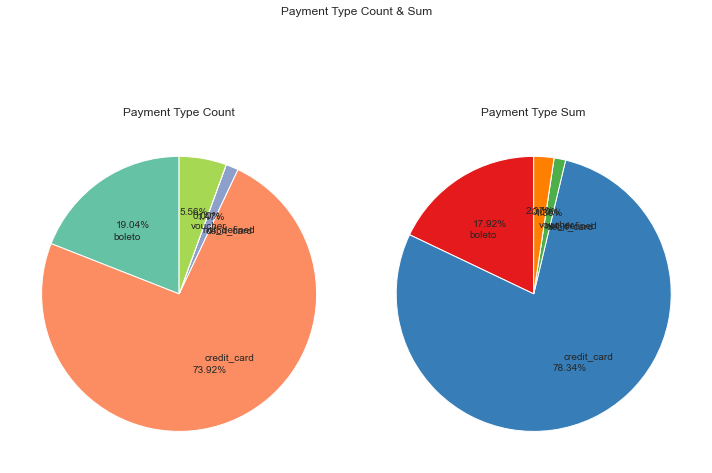

In [25]:
# order_payment values
payments = order_payment.groupby(['payment_type'])['payment_value'].agg(['count','sum']).reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2,figsize=(10,8))
fig.suptitle('Payment Type Count & Sum')

ax1.pie(payments['count'], labels=payments['payment_type'], autopct='%1.2f%%', startangle=90, colors=sns.color_palette('Set2'),labeldistance=0.5, pctdistance=0.6)
ax1.set_title('Payment Type Count')
ax2.pie(payments['sum'], labels=payments['payment_type'], autopct='%1.2f%%', startangle=90, colors=sns.color_palette('Set1'),labeldistance=0.5, pctdistance=0.6)
ax2.set_title('Payment Type Sum')
plt.tight_layout()
plt.show()


In [44]:
def bar_plot(df,col):
    # plot data in stack manner of bar type
    
    fig, ax = plt.subplots(figsize = (10,10))
    color = (0.2, # redness
             0.4, # greenness
             0.2, # blueness
             0.6 # transparency
             )

    ax.bar(
        x = df.index,
        height=df[col],
        tick_label=df.index,
        color = color
    )
    
    # First, let's remove the top, right and left spines (figure borders)
    # which really aren't necessary for a bar chart.
    # Also, make the bottom spine gray instead of black.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    
    # Second, remove the ticks as well.
    ax.tick_params(bottom=False, left=False)
    
    # Third, add a horizontal grid (but keep the vertical grid hidden).
    # Color the lines a light gray as well.
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    
    plt.show()
        

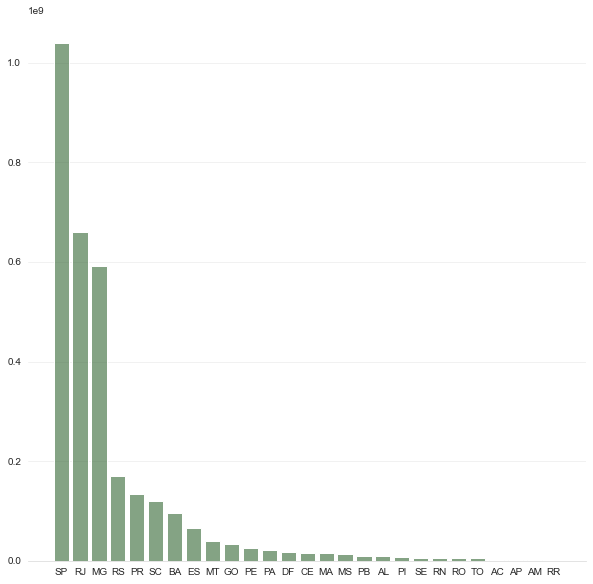

In [45]:
# payments per city
payments_geo = pd.pivot_table(customers_order, values = 'payment_value', index = ['customer_state'], columns = 'payment_type', aggfunc= 'sum')
payments_geo.fillna(0,inplace = True)
payments_geo['total'] = payments_geo['boleto'] + payments_geo['credit_card']+payments_geo['debit_card']+payments_geo['voucher']
payments_geo = payments_geo.sort_values(by = 'total', ascending= False)
# plot data in stack manner of bar type

bar_plot(payments_geo,'total')


In [41]:
# Top 20 Products 
products_sales = customers_order.groupby(['product_category_name','product_id'])['payment_value'].agg(['count']).reset_index().sort_values(by = 'count', ascending= False)

products_sales.head(20)

,product_category_name,product_id,count
23274,moveis_decoracao,aca2eb7d00ea1a7b8ebd4e68314663af,86104
18003,ferramentas_jardim,422879e10f46682990de24d770e7f83d,80749
9029,cama_mesa_banho,99a4788cb24856965c36a24e339b6058,78076
17972,ferramentas_jardim,389d119b48cf3043d311335e499d9c6b,59887
19957,informatica_acessorios,d1c427060a0f73f6b889a5c7c61f2ac4,58375
17960,ferramentas_jardim,368c6c730842d78016ad823897a372db,58076
18065,ferramentas_jardim,53759a2ecddad2bb87a079a1f1519f73,52252
27600,relogios_presentes,53b36df67ebb7c41585e8d54d6772e08,51470
3571,beleza_saude,154e7e31ebfa092203795c972e5804a6,42606
19038,informatica_acessorios,3dd2a17168ec895c781a9191c1e95ad7,40600


In [48]:
# Purchase yearly (check its trend) -- extraction
customers_order[['order_purchase_timestamp','payment_value','geolocation_state','price'],:]


0     2017-05-16 15:05:35
1     2017-05-16 15:05:35
2     2017-05-16 15:05:35
3     2017-05-16 15:05:35
4     2017-05-16 15:05:35
5     2017-05-16 15:05:35
6     2017-05-16 15:05:35
7     2017-05-16 15:05:35
8     2017-05-16 15:05:35
9     2017-05-16 15:05:35
10    2017-05-16 15:05:35
11    2017-05-16 15:05:35
12    2017-05-16 15:05:35
13    2017-05-16 15:05:35
14    2017-05-16 15:05:35
15    2017-05-16 15:05:35
16    2017-05-16 15:05:35
17    2017-05-16 15:05:35
18    2017-05-16 15:05:35
19    2017-05-16 15:05:35
Name: order_purchase_timestamp, dtype: object

In [49]:
customers_order.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state'],

# Sentiment Analysis

In [53]:
df_review = customers_order.loc[:,['review_score','review_comment_message']]
df_review = df_review.dropna(subset = ['review_comment_message'])
df_review.columns = ['score','comment']
df_review.head()

,score,comment
735,5.0,"Estou muito satisfeita ,o produto é lindo,perf..."
736,5.0,"Estou muito satisfeita ,o produto é lindo,perf..."
737,5.0,"Estou muito satisfeita ,o produto é lindo,perf..."
738,5.0,"Estou muito satisfeita ,o produto é lindo,perf..."
739,5.0,"Estou muito satisfeita ,o produto é lindo,perf..."


## Time Series Analysis